In [2]:
import pandas as pd
df = pd.read_pickle("twitts")
df.index = [i for i in range(len(df))]

In [3]:
df.head(3)

,screen_name,date_time,location,text
0,TheSkubis,2021-03-30 23:59:19,"Pennsylvania, USA",@VerizonSupport I have issues with closed capt...
1,VerizonSupport,2021-03-30 23:56:55,,@_carolinek This could be due to regional rest...
2,VerizonSupport,2021-03-30 23:55:30,,@tvmurray We'll be happy to help with anything...



### Pre-processing tweets

Провести обработку текста:

    -удалить стоп-слова 0
    -найти обращения по @ или хэштеги
    -найти ссылки на сайты
    -разбить по словам и n-граммы


Вопрос 1 Зачем в данном случае нужны n-граммы?

In [4]:
import re
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import time

start_time = time.time() 

tokenizer = TweetTokenizer()
tokenized_tweets = [tokenizer.tokenize(t) for t in df.text]

stop_words = stopwords.words("english")
stop_words.extend(["&amp;", "&gt;", "&lt;"])
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

clean_text = []
handles = []
hashtags = []
carrier = []
links = []
# простой пример pre-processing
for tweet in tokenized_tweets:

    thandles = []
    thashtags = []
    joined_words = " "
    words = [w.lower() for w in tweet if len(w)>2 and w not in stop_words]
    thandles = [w for w in words if re.search("^@\w+", w)]
    tlinks = [w for w in words if re.search("^https:\w+", w)]
#     print(tlinks)
    thashtags = [w for w in words if re.search("^#\w+", w)]
    words = [w for w in words if w.isalpha() and w not in thandles and w not in thashtags and w not in tlinks]
    words = [lemmatizer.lemmatize(w) for w in words]
    
    joined_words = joined_words.join(words)
    tlength = len(joined_words)
    handles.append(thandles)
    hashtags.append(thashtags)
    links.append(tlinks)
    clean_text.append(joined_words)

In [5]:
df['clean_text'] = clean_text
df['handles'] = handles
df['hashtags'] = hashtags
df['links'] = links
df.head()

,screen_name,date_time,location,text,clean_text,handles,hashtags,links
0,TheSkubis,2021-03-30 23:59:19,"Pennsylvania, USA",@VerizonSupport I have issues with closed capt...,issue closed caption walking dead show display...,[@verizonsupport],[],[]
1,VerizonSupport,2021-03-30 23:56:55,,@_carolinek This could be due to regional rest...,this could due regional restriction have check...,[@_carolinek],[],[]
2,VerizonSupport,2021-03-30 23:55:30,,@tvmurray We'll be happy to help with anything...,happy help anything related fios twitter pleas...,[@tvmurray],[],[]
3,_carolinek,2021-03-30 23:55:24,,@VerizonSupport Hi! I know you think you can h...,know think help literally month trying help th...,[@verizonsupport],[],[]
4,VerizonSupport,2021-03-30 23:54:26,,@lam3014 We will be happy to look into this fo...,happy look please send direct message follow v...,[@lam3014],[],[]


In [6]:
# n-grams
# import nltk
# # nltk.download('wordnet')
# from nltk import ngrams
# import collections as c
# all_grams = []
# for string in df.text:
#     gram_2 = []
#     for i in ngrams(string.split(),2):
# #         print(i)
#         gram_2.append(i)
#     all_grams.append(gram_2)
# df['all_grams'] = all_grams
# df.head()

### Разработка сегментов

### Вопрос 1. - какие еще могут быть сегменты?

*Добавил субъективность

https://core.ac.uk/download/pdf/82425196.pdf

In [7]:
# pip install textblob

In [8]:

# изучить textblob
# https://textblob.readthedocs.io/en/dev/

from textblob import TextBlob
polarity = [0.0]*len(df)
subjectivity = [0.5]*len(df)
sentiment = [""]*len(df)
fact = [""]*len(df)
for i in df.index:
#     print(df.clean_text[i])
    blob = TextBlob(str(df.clean_text[i]))
    polarity[i] = blob.polarity
    subjectivity[i] = blob.subjectivity
    
#     # разбивки на сегменты 
#     # а какие способы ты знаешь ещё?
    if polarity[i] > 0.0:
        sentiment[i] = "pos"
    elif polarity[i] < 0.0:
        sentiment[i] = "neg"
    else:
        sentiment[i] = "neu"
        
    if subjectivity[i] > 0.5:
        fact[i] = 0
    else:
        fact[i] = 1
    
df["sentiment"]    = sentiment
df["polarity"]     = polarity
df["subjectivity"] = subjectivity
df['fact'] = fact

### Вопрос 2. - нужен ли emoji analysis???

  -https://pypi.org/project/emosent-py/
  
  -https://github.com/ajinkyachavan/Emoticon-Based-Sentiment-Analysis-Python/blob/master/emoticon-based-sentiment-analysis-of-twitter-data.pdf

In [9]:
# проработать emoji - отражают возраст

# emoji = []
# for i in df.text:
#     emo = re.findall(r'[^\w\s,-@\'\^…’!#$)(+*“&”~|%]',i)
#     emoji.append(emo)
# df['emoji'] = emoji


### Сделаем разбивку по операторам



###  Вопрос 3. В чем смысл этой функции, если мы загружали данные через tweepy  изначально по операторам?

In [10]:
# создадим колонку, которая укажет, какой это оператор

# def carrier(df,name):
#     carrier = []

#     for text in df[['screen_name','text']].values:
#         screen_name = text[0].lower()
#         twitter_text = text[1].lower()
#         current_carrier = []
#         if name.lower() in twitter_text or name.lower() in screen_name:
#             current_carrier.append(name)

#         ... 
#         carrier.append(' '.join(current_carrier))
#     df['carrier'] = carrier
#     return df



In [11]:
carrier = []
def carrier (df,name):
    for text in df[['screen_name','text']].values:
        screen_name = text[0].lower()
        twitter_text = text[1].lower()
        current_carrier = []
        if name.lower() in twitter_text or name.lower() in screen_name:
            df.loc[df[df['text'] == text[1]].index,'carrier'] = name.lower()
    return df

# df = carrier(df,'VZWSupport')
# df.head()

In [12]:
car = ['verizon','VerizonSupport','VZWSupport','ATT','ATTHelp','TMobile','TMobileHelp']
for i in car:
    df = carrier(df,i)
#     print(df['carrier'].unique())

###  Вопрос 4.зачем эта часть кода - токенайзер делали выше?

In [13]:
# сделай какой-нибудь токинайзер
# https://ru.wikipedia.org/wiki/%D0%9B%D0%B5%D0%BA%D1%81%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8%D0%B9_%D0%B0%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7
# https://docs.python.org/3/library/tokenize.html

# tokenized_tweets = [tokenizer.tokenize(t) for t in df.text]
# clf_text = []
# for tweet in tokenized_tweets:
#     joined_words = " "
#     words = [w.lower() for w in tweet if w.isalpha() or w[0]=='@']
#     tlinks = [w for w in words if re.search("^https:\w+", w)]
#     words = [w for w in words if  w not in tlinks]
#     joined_words = joined_words.join(words)
#     clf_text.append(joined_words)

# df["clf_text"] = clf_text

### Сделай обзор по группам (EDA)

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt 

In [15]:
clean_df = df[~df['carrier'].isna()][['screen_name','carrier','location','date_time','clean_text','polarity','sentiment','fact']]
clean_df

,screen_name,carrier,location,date_time,clean_text,polarity,sentiment,fact
0,TheSkubis,verizonsupport,"Pennsylvania, USA",2021-03-30 23:59:19,issue closed caption walking dead show display...,-0.150000,neg,1
1,VerizonSupport,verizonsupport,,2021-03-30 23:56:55,this could due regional restriction have check...,-0.125000,neg,1
2,VerizonSupport,verizonsupport,,2021-03-30 23:55:30,happy help anything related fios twitter pleas...,0.400000,pos,0
3,_carolinek,verizonsupport,,2021-03-30 23:55:24,know think help literally month trying help th...,0.000000,neu,1
4,VerizonSupport,verizonsupport,,2021-03-30 23:54:26,happy look please send direct message follow v...,0.450000,pos,0
...,...,...,...,...,...,...,...,...
695,bravosfan1025,tmobilehelp,Erie PA,2021-03-30 22:40:49,line though and referring,0.000000,neu,1
696,TMobileHelp,tmobilehelp,"Bellevue, WA",2021-03-30 22:40:01,hey experience super important want make sure ...,0.411111,pos,0
697,TMobileHelp,tmobilehelp,"Bellevue, WA",2021-03-30 22:39:22,thank reaching today ryan the essential plan a...,0.000000,neu,1
698,TMobileHelp,tmobilehelp,"Bellevue, WA",2021-03-30 22:36:19,committed providing reliable service need stay...,0.000000,neu,1


In [16]:
# добавим месяц,час,dummy-переменную sentiment и длину текстового сообщения

import datetime as dt
clean_df['month'] = clean_df['date_time'].dt.month
clean_df['hour'] = clean_df['date_time'].dt.hour
clean_df['sense_dummy'] = clean_df['sentiment'].apply(lambda x: 1 if x == 'pos' else (0 if x == 'neu' else -1))
clean_df['text_len'] = clean_df['clean_text'].apply(lambda x:len(x))
clean_df.drop('sentiment',inplace = True,axis = 1)
# clean_df['len_emoji'] = clean_df['emoji'].apply(lambda x:len(x))
clean_df['day'] = df['date_time'].dt.weekday
clean_df.head(3)

,screen_name,carrier,location,date_time,clean_text,polarity,fact,month,hour,sense_dummy,text_len,day
0,TheSkubis,verizonsupport,"Pennsylvania, USA",2021-03-30 23:59:19,issue closed caption walking dead show display...,-0.150,1,3,23,-1,51,1
1,VerizonSupport,verizonsupport,,2021-03-30 23:56:55,this could due regional restriction have check...,-0.125,1,3,23,-1,52,1
2,VerizonSupport,verizonsupport,,2021-03-30 23:55:30,happy help anything related fios twitter pleas...,0.400,0,3,23,1,63,1


In [17]:
clean_df.describe()


,polarity,fact,month,hour,sense_dummy,text_len,day
count,649.000000,649.000000,649.0,649.000000,649.000000,649.000000,649.0
mean,0.100508,0.704160,3.0,22.306626,0.229584,46.661017,1.0
std,0.289867,0.456771,0.0,1.031885,0.676766,19.779004,0.0
min,-1.000000,0.000000,3.0,19.000000,-1.000000,0.000000,1.0
25%,0.000000,0.000000,3.0,22.000000,0.000000,37.000000,1.0
50%,0.000000,1.000000,3.0,23.000000,0.000000,48.000000,1.0
75%,0.214286,1.000000,3.0,23.000000,1.000000,60.000000,1.0
max,1.000000,1.000000,3.0,23.000000,1.000000,106.000000,1.0


In [18]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 649 entries, 0 to 699
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   screen_name  649 non-null    object        
 1   carrier      649 non-null    object        
 2   location     649 non-null    object        
 3   date_time    649 non-null    datetime64[ns]
 4   clean_text   649 non-null    object        
 5   polarity     649 non-null    float64       
 6   fact         649 non-null    int64         
 7   month        649 non-null    int64         
 8   hour         649 non-null    int64         
 9   sense_dummy  649 non-null    int64         
 10  text_len     649 non-null    int64         
 11  day          649 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(6), object(4)
memory usage: 65.9+ KB


In [19]:
clean_df.head(3)

,screen_name,carrier,location,date_time,clean_text,polarity,fact,month,hour,sense_dummy,text_len,day
0,TheSkubis,verizonsupport,"Pennsylvania, USA",2021-03-30 23:59:19,issue closed caption walking dead show display...,-0.150,1,3,23,-1,51,1
1,VerizonSupport,verizonsupport,,2021-03-30 23:56:55,this could due regional restriction have check...,-0.125,1,3,23,-1,52,1
2,VerizonSupport,verizonsupport,,2021-03-30 23:55:30,happy help anything related fios twitter pleas...,0.400,0,3,23,1,63,1


In [20]:
# описание по среднему и count
polarity_by_carrier = clean_df.groupby('carrier').agg('mean')
polarity_by_carrier

,polarity,fact,month,hour,sense_dummy,text_len,day
carrier,,,,,,,
att,0.081079,0.709677,3.0,22.623656,0.236559,40.129032,1.0
atthelp,0.038738,0.846939,3.0,21.459184,0.132653,52.418367,1.0
tmobile,0.086727,0.875000,3.0,22.927083,0.208333,41.572917,1.0
tmobilehelp,0.176543,0.518182,3.0,22.718182,0.363636,47.972727,1.0
verizon,0.038265,0.794118,3.0,23.000000,0.132353,52.088235,1.0
verizonsupport,0.130141,0.613636,3.0,21.943182,0.261364,45.670455,1.0
vzwsupport,0.125971,0.614583,3.0,21.614583,0.229167,47.760417,1.0


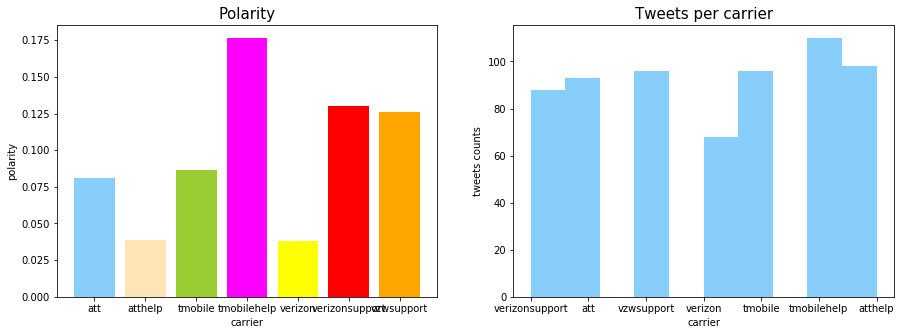

In [21]:

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.bar(polarity_by_carrier.index,polarity_by_carrier['polarity'],color=['lightskyblue','moccasin','yellowgreen','magenta','yellow','red','orange'])
plt.title('Sentiments polarity per carrier', fontsize=15)
plt.xlabel('carrier')
plt.ylabel('polarity')
plt.title('Polarity', fontsize=15)

# распределение количества операторов в дф
plt.subplot(122)
plt.hist(clean_df['carrier'],align = 'mid',rwidth=2,color = 'lightskyblue')
plt.xlabel('carrier')
plt.ylabel('tweets counts')
plt.title('Tweets per carrier', fontsize=15)
plt.show()

In [22]:
# распределение по сентиментам
clean_df.groupby('sense_dummy')['carrier'].agg('count')

sense_dummy
-1     91
 0    318
 1    240
Name: carrier, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000198A365BC88>,
      dtype=object)

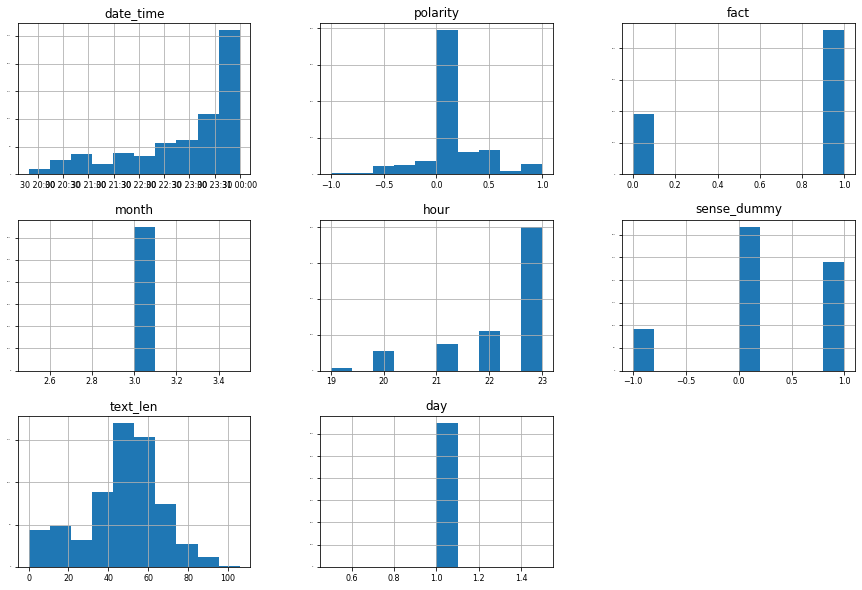

In [23]:
# распределение всех числовых фичей

clean_df.hist(figsize=(15, 10), bins=10, xlabelsize=8, ylabelsize=2)

In [24]:
# боксплот по длине слов в корпусе
# sns.boxplot(clean_df['text_len'])

In [25]:
# heatmap - с лекции по numpy
# выделение столбцов для heatmap корреляции
# cor_col=['fact','month','hour','text_len','len_emoji','day']
# target = clean_df['sense_dummy']

# def plot_correlation_map( df ):
#     corr = df.corr()
#     _ , ax = plt.subplots( figsize =( 12 , 10 ) )
#     cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
#     _ = sns.heatmap(
#         corr, 
#         cmap = cmap,
#         square=True, 
#         cbar_kws={ 'shrink' : .9 }, 
#         ax=ax, 
#         annot = True, 
#         annot_kws = { 'fontsize' : 12 }
#     )
# plot_correlation_map( clean_df )

### Определи, какие слова наиболее характерны для операторов

  * какие cлова чаще, чем остальные встречаются для определенного оператора

In [26]:
# функция подсчета слов для оператора

from collections import Counter


# car = 'VerizonSupport'
# carrier_corpus = []
# for t  in clean_df[clean_df['carrier']== car]['clean_text']:
#     for j in t.split():
#         carrier_corpus.append(j)
        
# total_term_frequency = Counter(carrier_corpus)
# for word, freq in total_term_frequency.most_common(10):
#     word_dist = {}
#     word_dist[word] = freq
# #     print("{}\t{}".format(word, freq))
#     plt.bar(word_dist.keys(), word_dist.values(), color='g')
# car = 'VerizonSupport'
def word_frequency_bar(clean_df,carrier_name):
    carrier_corpus = []
    for t  in clean_df[clean_df['carrier']== carrier_name]['clean_text']:
        for j in t.split():
            carrier_corpus.append(j)

    total_term_frequency = Counter(carrier_corpus)
    word_dist = {}
    for word, freq in total_term_frequency.most_common(10):
        word_dist[word] = freq
#         print ("{}\t{}".format(word, freq))
        plt.bar(word_dist.keys(), word_dist.values(), color='g')

# word_frequency_bar(clean_df,car)


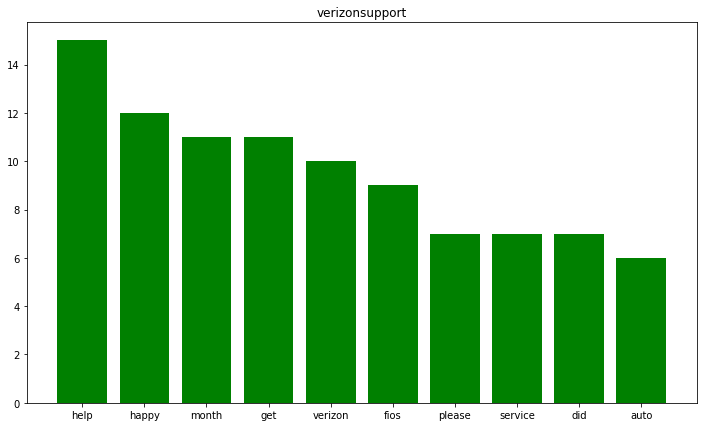

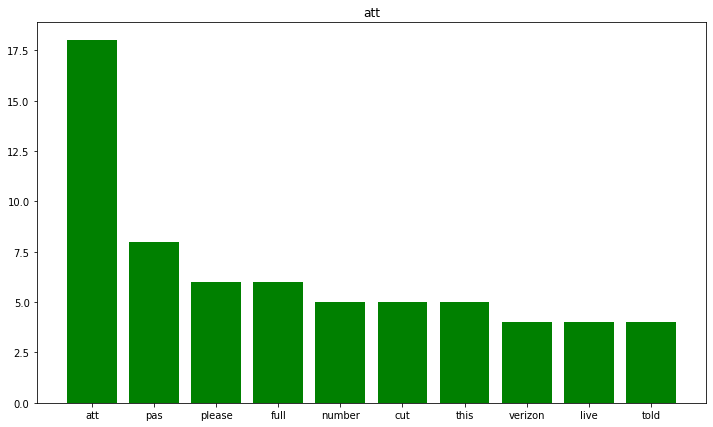

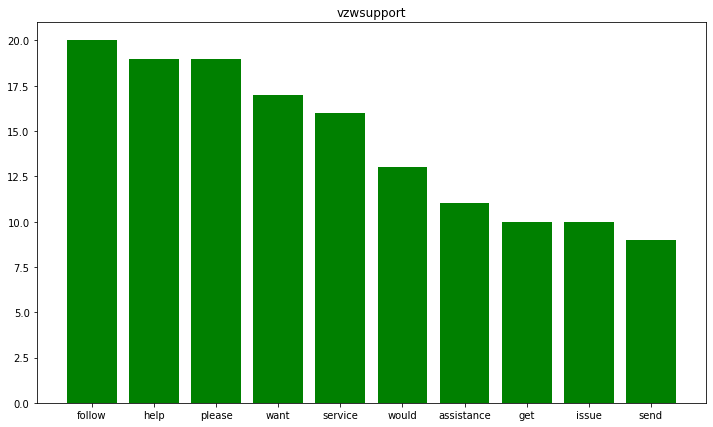

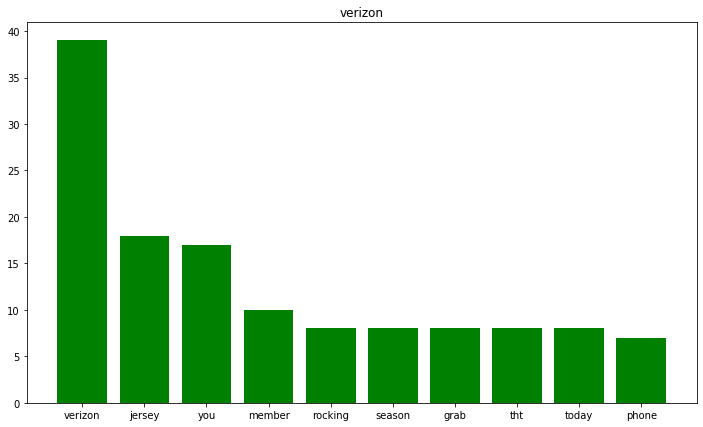

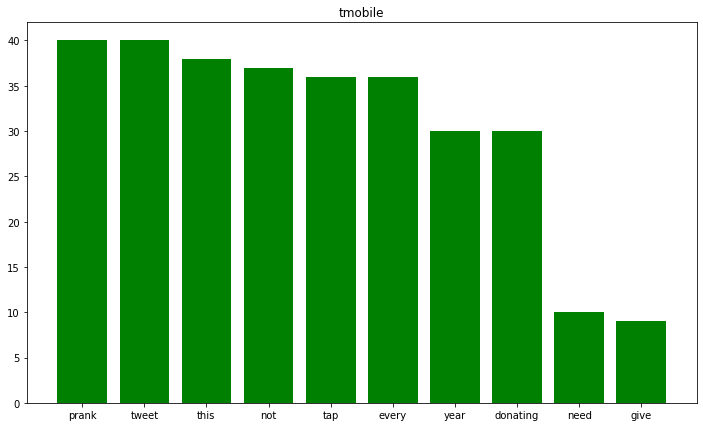

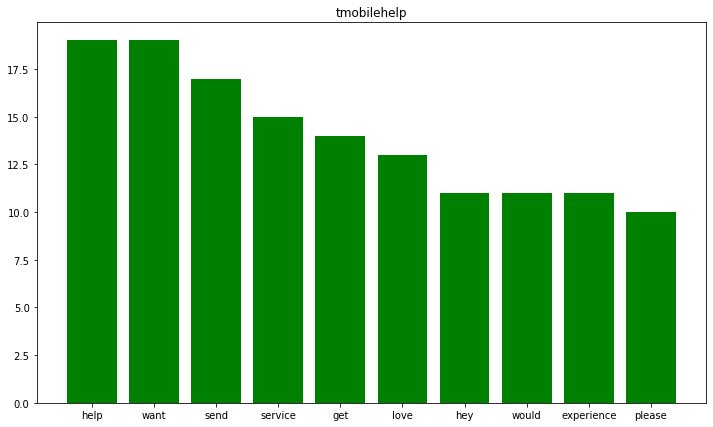

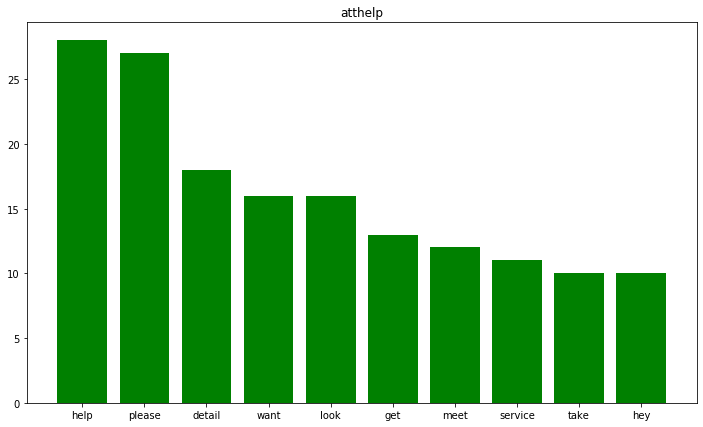

In [27]:
# графики распределения слов для каждого оператора

# fig, axs = plt.subplots(len(clean_df['carrier'].unique()), 1, figsize=(12, 7))
for i in clean_df['carrier'].unique():
    fig, axs = plt.subplots(1, 1, figsize=(12, 7))
    word_frequency_bar(clean_df,i)
    plt.title(i)

* посмотреть распределения по словам, относительно операторов

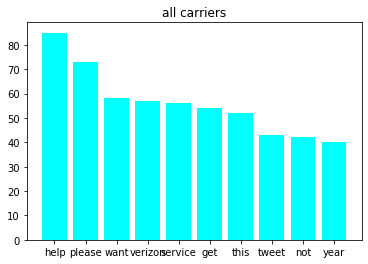

In [28]:
# распределение слов по всем операторам 

all_text = []
for s in  clean_df['clean_text']:
    for j in s.split():
            all_text.append(j)

total_term_frequency = Counter(all_text)
word_dist = {}
for word, freq in total_term_frequency.most_common(10):
    word_dist[word] = freq
#         print ("{}\t{}".format(word, freq))
    plt.bar(word_dist.keys(), word_dist.values(), color='cyan')
    plt.title('all carriers')

In [29]:
# pip install WordCloud

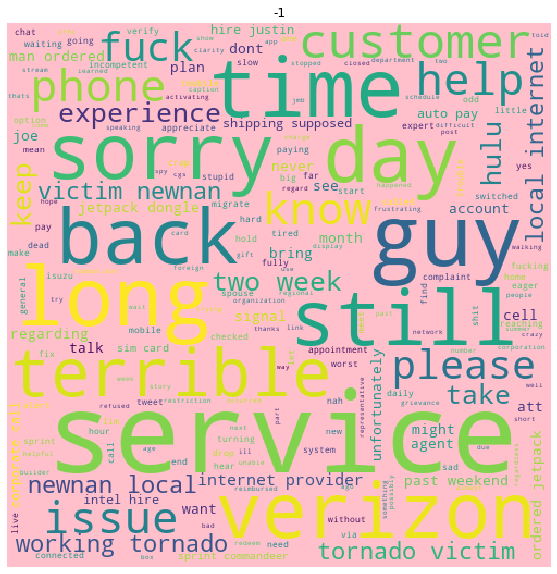

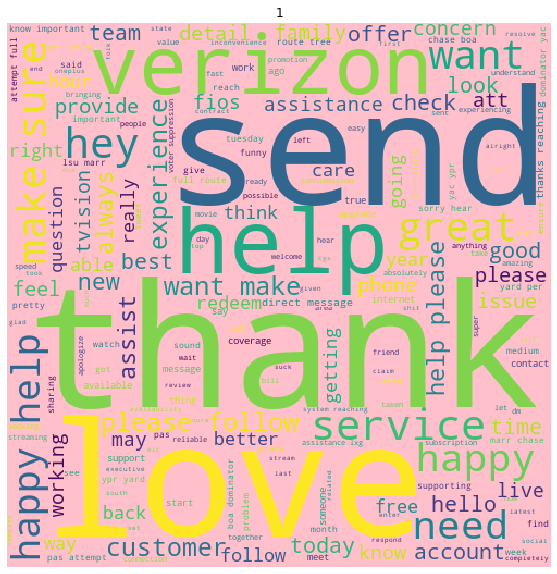

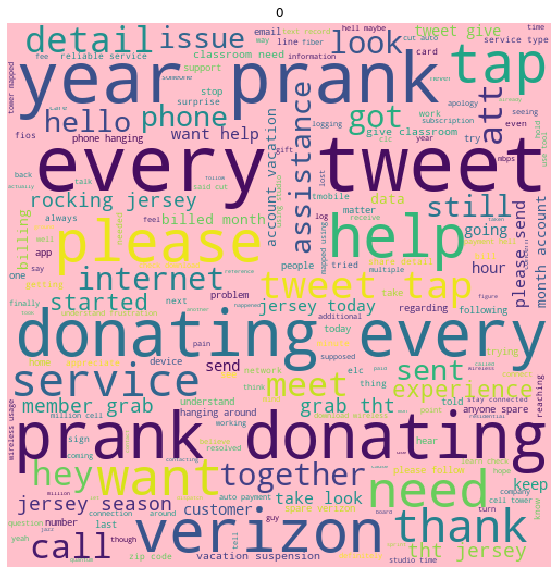

In [30]:
# word cloud по сентиментам

# https://www.analyticsvidhya.com/blog/2020/04/beginners-guide-exploratory-data-analysis-text-data/

# Importing wordcloud for plotting word clouds and textwrap for wrapping longer text
from wordcloud import WordCloud
from textwrap import wrap
def plot_cloud(wordcloud):
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud) 
    plt.axis("off");

for sense in clean_df['sense_dummy'].unique():
    text = ''
    for t in clean_df[clean_df['sense_dummy'] == sense]['clean_text']:
        text+=t+' '
    wordcloud = WordCloud(width = 500, height = 500, background_color='pink', random_state=10).generate(text)
    plot_cloud(wordcloud)
    plt.title(sense)
    


      


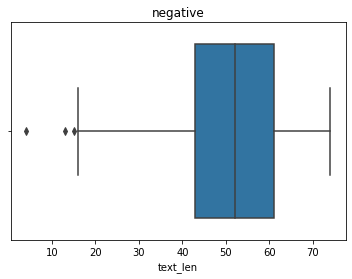

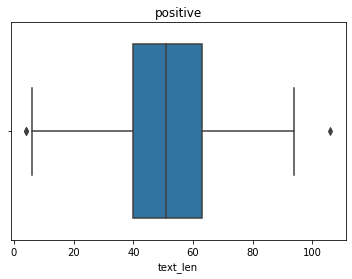

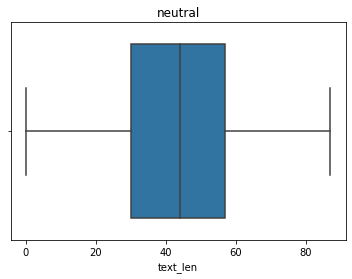

In [31]:
# боксплоты для каждой категории сентимента

for i in clean_df['sense_dummy'].unique():
    plt.figure()
    if i == 1:
        sns.boxplot(clean_df[clean_df['sense_dummy'] == i]['text_len']).set_title('positive')
    elif i == 0:
        sns.boxplot(clean_df[clean_df['sense_dummy'] == i]['text_len']).set_title('neutral')
    else:
        sns.boxplot(clean_df[clean_df['sense_dummy'] == i]['text_len']).set_title('negative')



###  Вопрос 5 . Зачем 2 пункта ниже?
 * пропобуй найти слова: помогите, бесплатно, обещали, покупатель, очень медленно

 * добавь свои слова ( к вышепредставленным) и сделай топ-20

In [32]:
# подсчет  указанных слов

# churny_words = ['help','for free','promised','buyer','very slow','switch','change','leave','stay with','bye-bye','can\'t take','horrible','loyal','awful','worth','numbered','contract is up','goodbye','turn','lost']
# from collections import defaultdict
# churny_words_counter = defaultdict(int)

# for word in churny_words:
#     for i in clean_df['clean_text']:
#         if word in i:
#             churny_words_counter[word]+=1
            
# churny_words_counter

### Определи время и как время сообщения распределено по времени

* определи месяц, день недели, день месяца, время дня, часть дня (до обеда, день, вечер - например)

In [33]:
# добавим 2 столбца : день месяца и часть дня
clean_df['day_of_month'] = clean_df['date_time'].dt.day
clean_df['part_of_day'] = clean_df['hour'].apply(lambda x: 'night' if 0<x<5 else ('morning' if 6<x<10 else ('day' if 11<x<18 else "evening") ))



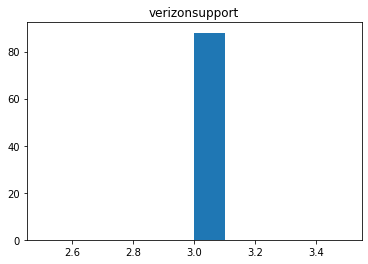

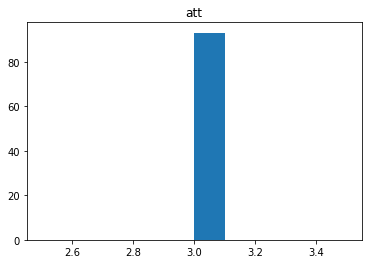

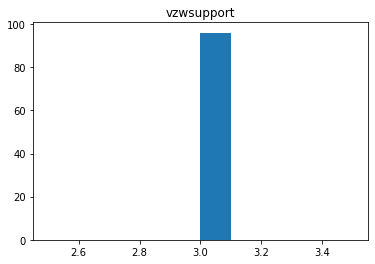

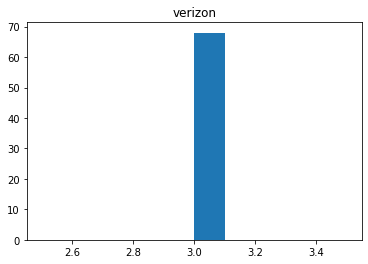

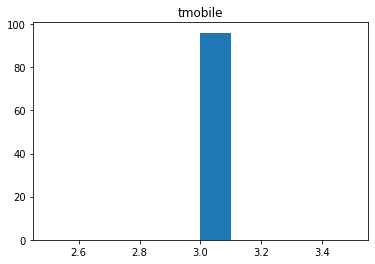

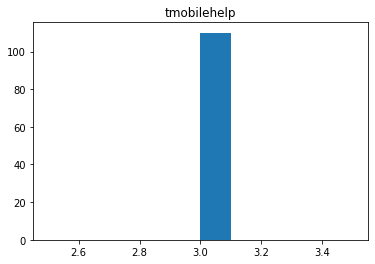

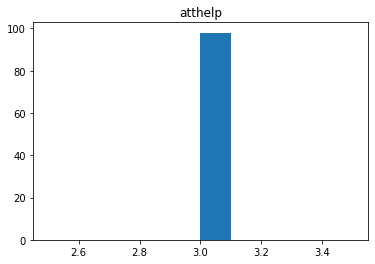

In [34]:
# распределение по месяцам
for carrier in clean_df['carrier'].unique():
    fig,axs = plt.subplots(1,1)
    plt.hist(clean_df[clean_df['carrier'] == carrier]['month'])
    plt.title(carrier)

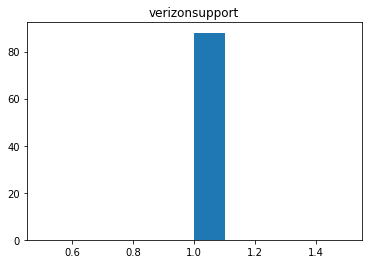

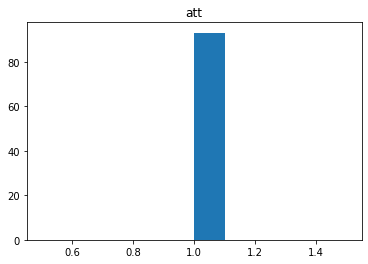

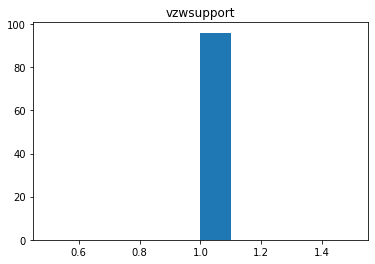

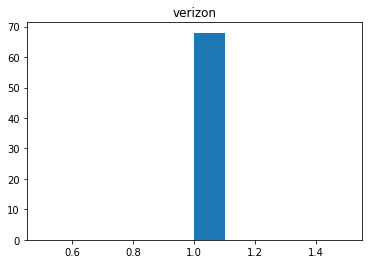

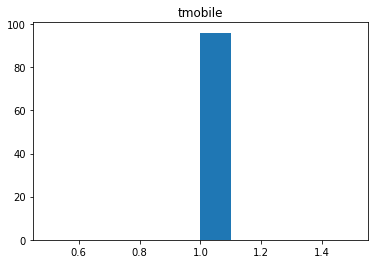

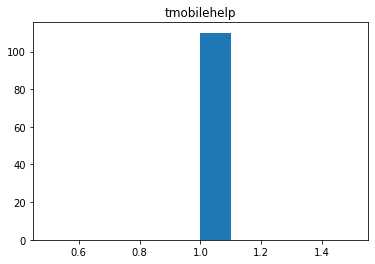

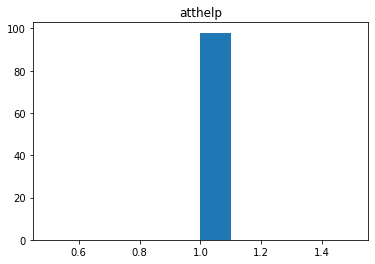

In [35]:
# по дням недели
for carrier in clean_df['carrier'].unique():
    fig,axs = plt.subplots(1,1)
    plt.hist(clean_df[clean_df['carrier'] == carrier]['day'])
    plt.title(carrier)

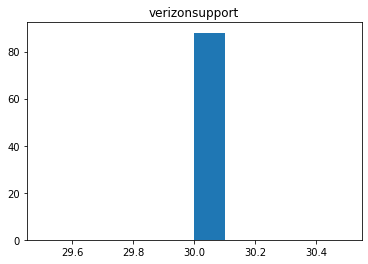

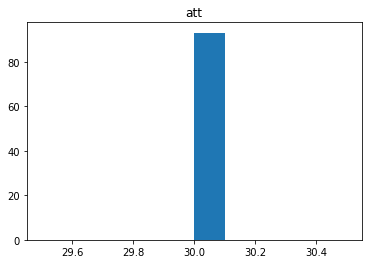

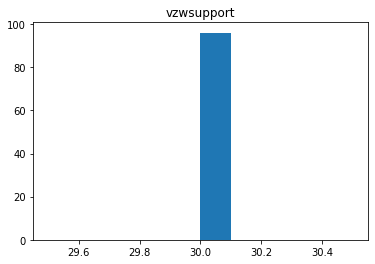

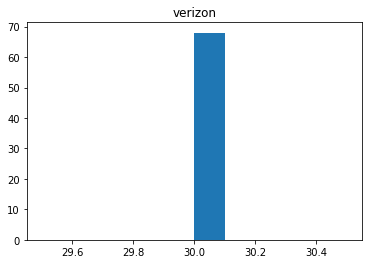

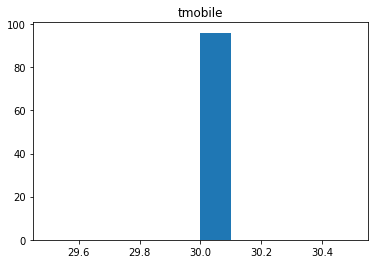

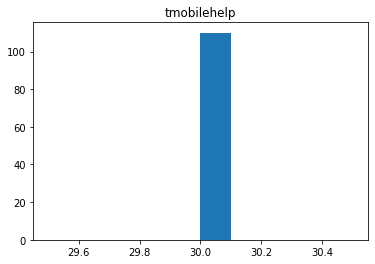

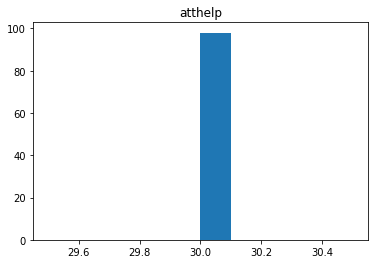

In [36]:
# по числу месяца
for carrier in clean_df['carrier'].unique():
    fig,axs = plt.subplots(1,1)
    plt.hist(clean_df[clean_df['carrier'] == carrier]['day_of_month'])
    plt.title(carrier)

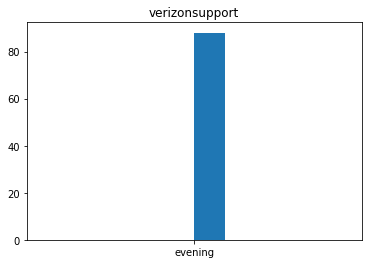

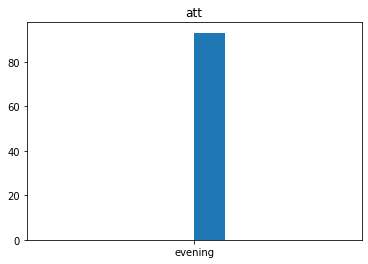

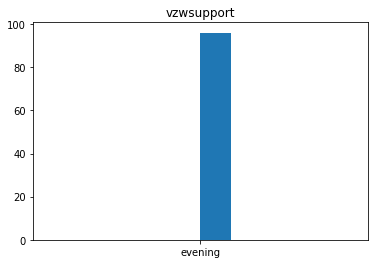

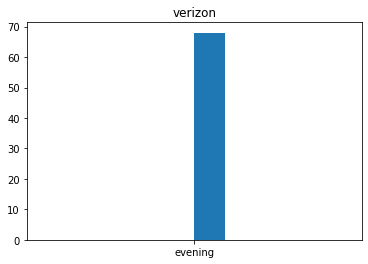

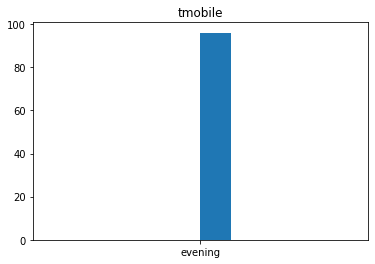

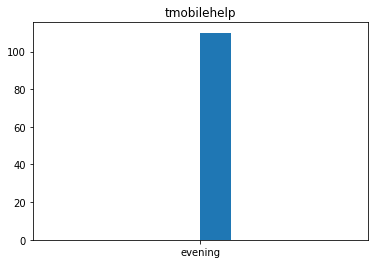

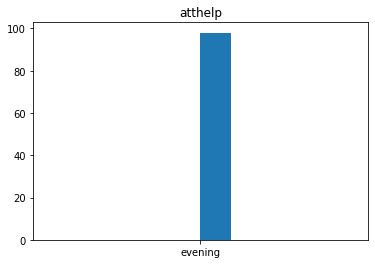

In [37]:
# по периоду дня
for carrier in clean_df['carrier'].unique():
    fig,axs = plt.subplots(1,1)
    plt.hist(clean_df[clean_df['carrier'] == carrier]['part_of_day'])
    plt.title(carrier)

###  Вопрос 5 .какая логика формулы преобразования sin cosine - это перевод в радианы? это потом пойдет в модель

In [38]:
# преобразование циклических данных
import numpy as np

seconds_in_day = 24*60*60
clean_df['seconds']= clean_df['date_time'].dt.second
clean_df['sin_time'] = np.sin(2*np.pi*clean_df.seconds/seconds_in_day)
clean_df['cos_time'] = np.cos(2*np.pi*clean_df.seconds/seconds_in_day)

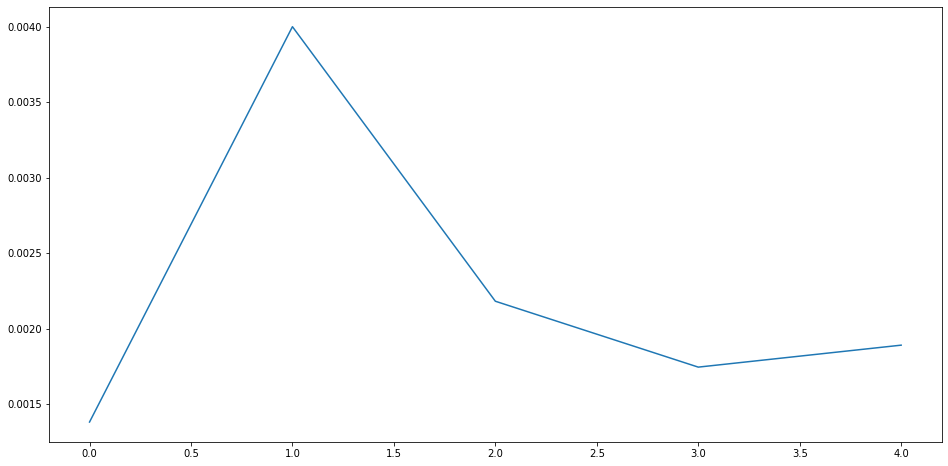

In [39]:
clean_df.sin_time.head(5).plot(figsize = (16,8))

### Сделай распределения и обзор по сентиментному анализу относительно операторов

In [40]:
# посмотрим процентное распределение сентиментов по операторам

from statsmodels.api import stats
df_conflux = clean_df[['carrier','sense_dummy']]
table1 = stats.Table.from_data(df_conflux)
df_conflux = pd.DataFrame(table1.table_orig)
# for i in df_conflux.columns:
#     print(type(i))
#     print(i)
df_conflux['neg %'] = df_conflux[-1]/(df_conflux[-1]+df_conflux[1]+df_conflux[0])
df_conflux['pos %'] = df_conflux[1]/(df_conflux[-1]+df_conflux[1]+df_conflux[0])
df_conflux['neu %'] = df_conflux[0]/(df_conflux[-1]+df_conflux[1]+df_conflux[0])
df_conflux

sense_dummy,-1,0,1,neg %,pos %,neu %
carrier,,,,,,
att,10,51,32,0.107527,0.344086,0.548387
atthelp,11,63,24,0.112245,0.244898,0.642857
tmobile,4,68,24,0.041667,0.250000,0.708333
tmobilehelp,23,24,63,0.209091,0.572727,0.218182
verizon,9,41,18,0.132353,0.264706,0.602941
verizonsupport,15,35,38,0.170455,0.431818,0.397727
vzwsupport,19,36,41,0.197917,0.427083,0.375000


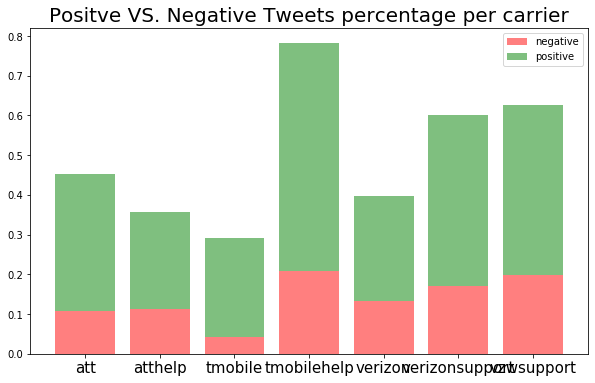

In [41]:
plt.figure(figsize=(10,6))
p1 = plt.bar(df_conflux.index, df_conflux['neg %'], color='r',label='negative',alpha=0.5)
p2 = plt.bar(df_conflux.index, df_conflux['pos %'], bottom=df_conflux['neg %'], color='g', label='positive',alpha=0.5)
# p3 = plt.bar(df_conflux.index, df_conflux['neu %'], bottom= df_conflux['pos %'], color='b', label='neutral',alpha=0.5)
plt.legend()
plt.xticks(fontsize=15)
plt.title('Positve VS. Negative Tweets percentage per carrier', fontsize=20)
plt.show()

Text(0, 0.5, 'Tweet Count')

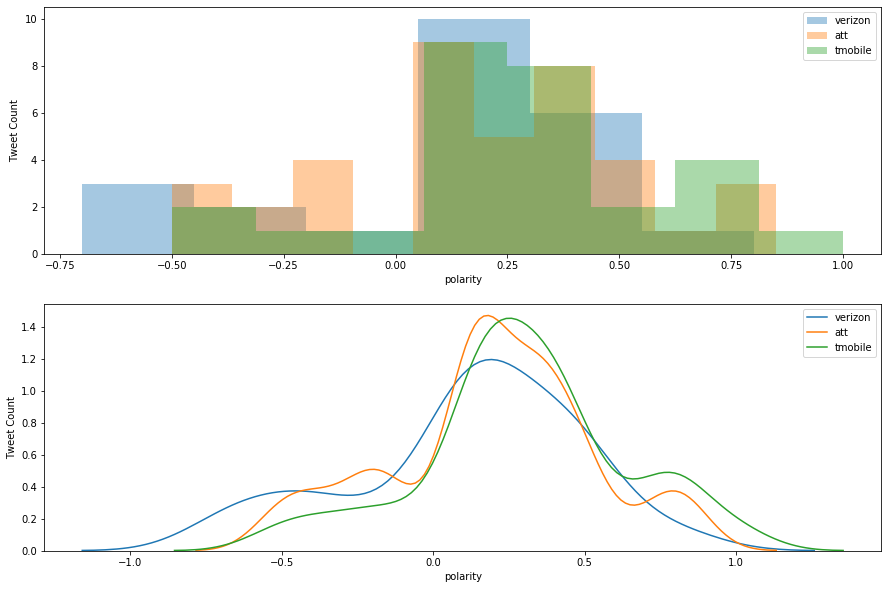

In [42]:
# for carrier in clean_df[clean_df['carrier'].unique():
plt.figure(figsize=(15,10))
plt.subplot(211)
polar_df = clean_df[(clean_df['polarity']>=0.05) | (clean_df['polarity']<=-0.05)]
sns.distplot(polar_df[polar_df['carrier'] == 'verizon']['polarity'], kde=False, hist=True, label="verizon")
sns.distplot(polar_df[polar_df['carrier'] == 'att']['polarity'], kde=False, hist=True, label="att")
sns.distplot(polar_df[polar_df['carrier'] == 'tmobile']['polarity'],kde=False, hist=True, label="tmobile")
plt.legend()
plt.ylabel("Tweet Count")

plt.subplot(212)
sns.distplot(polar_df[polar_df['carrier'] == 'verizon']['polarity'], kde=True, hist=False, label="verizon")
sns.distplot(polar_df[polar_df['carrier'] == 'att']['polarity'], kde=True, hist=False, label="att")
sns.distplot(polar_df[polar_df['carrier'] == 'tmobile']['polarity'],kde=True, hist=False, label="tmobile")
plt.legend()
plt.ylabel("Tweet Count")

In [43]:
clean_df.to_csv('upd_clean_df.csv')


### Создание репрезентативного словаря для негативны и позитивных твитов

In [44]:
# токенизация очищенного текста

# https://github.com/hundredblocks/concrete_NLP_tutorial/blob/master/NLP_notebook.ipynb

from nltk.tokenize import RegexpTokenizer



clean_df["tokens"] = clean_df["clean_text"].apply(tokenizer.tokenize)
all_words = [word for tokens in clean_df["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in clean_df["tokens"]]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

4776 words total, with a vocabulary size of 1414
Max sentence length is 15


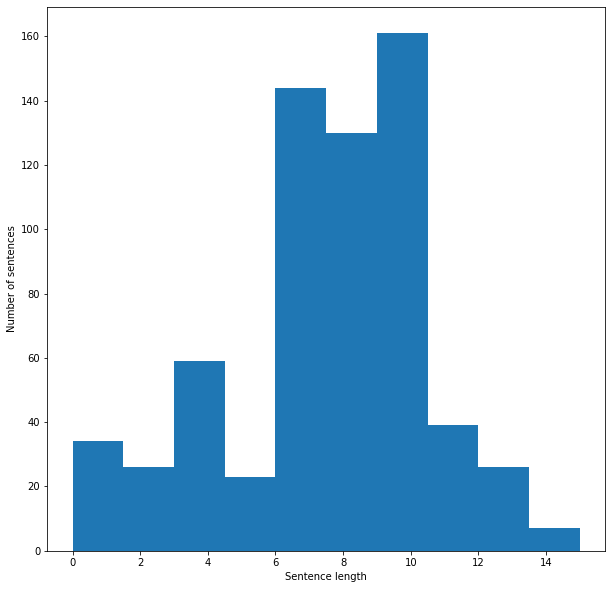

In [45]:
# уже есть boxplot выше - распределение предложений по длине
fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.hist(sentence_lengths)
plt.show()

In [46]:
# Bag of words
# https://habr.com/ru/company/Voximplant/blog/446738/

# Import the libraries we need
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# Step 2. Design the Vocabulary
# The default token pattern removes tokens of a single character. That's why we don't have the "I" and "s" tokens in the output
count_vectorizer = CountVectorizer()

# Step 3. Create the Bag-of-Words Model
bag_of_words = count_vectorizer.fit_transform(clean_df['clean_text'])

# Show the Bag-of-Words Model as a pandas DataFrame
feature_names = count_vectorizer.get_feature_names()
pd.DataFrame(bag_of_words.toarray(), columns = feature_names)


,able,absolutely,acce,access,account,across,acting,activating,active,actually,...,yikes,you,your,yours,youtube,ypr,yr,zip,𝐋𝐄𝐀𝐃𝐄𝐑,𝐓𝐇𝐄
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
645,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
646,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
647,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
# уже было выше - топ-10 слов
stops =  set(stopwords.words('english')+['com'])
co = CountVectorizer(stop_words=stops)
counts = co.fit_transform(clean_df.clean_text)
pd.DataFrame(counts.sum(axis=0),columns=co.get_feature_names()).T.sort_values(0,ascending=False).head(10)

,0
help,85
please,73
want,58
verizon,57
service,56
get,54
tweet,43
year,40
need,40
prank,40


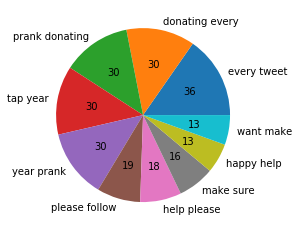

In [51]:
# топ-10 биграмм
co = CountVectorizer(ngram_range=(2,2),stop_words=stops)
counts = co.fit_transform(clean_df.clean_text)
top_bigrams = pd.DataFrame(counts.sum(axis=0),columns=co.get_feature_names()).T.sort_values(0,ascending=False).head(10)
total = sum(top_bigrams[0].values)
plt.pie(top_bigrams[0],labels = top_bigrams.index,autopct=lambda p: '{:.0f}'.format(p * total / 100))
# plt.legend(loc="upper left")
plt.show()

In [ ]:
import nltk
sense_dict = {}
for carrier in clean_df['carrier'].unique():
    print(carrier)
    for sense in clean_df['sense_dummy'].unique():
        text = ''
        for i in clean_df[(clean_df['sense_dummy'] == sense) & (clean_df['carrier'] == carrier)]['clean_text'].values:
    #         print(i)
            text+=i+''
            sense_dict[sense] = text.split()
    freq_dist_positive=nltk.FreqDist(sense_dict[1])
    freq_dist_negative=nltk.FreqDist(sense_dict[-1])
    print("Most Common Positive Words : ",freq_dist_positive.most_common(5))
    print("Most Common Negative Words : ",freq_dist_negative.most_common(5))
    fig, axs = plt.subplots(1, 1, figsize=(12, 7))
    plt.bar([x[0] for x in freq_dist_positive.most_common(5)],[x[1] for x in freq_dist_positive.most_common(5)])
    plt.title(carrier)
    plt.ylabel('most positive ')
    fig, axs = plt.subplots(1, 1, figsize=(12, 7))
    plt.bar([x[0] for x in freq_dist_negative.most_common(5)],[x[1] for x in freq_dist_negative.most_common(5)])
    plt.title(carrier)
    plt.ylabel('most negative ')

In [ ]:
plt.bar([x[0] for x in freq_dist_positive.most_common(5)],[x[1] for x in freq_dist_positive.most_common(5)])

In [ ]:
# https://github.com/Ashwani018/Amazon-Fine-Food-Reviews/blob/master/Amazon%20Fine%20Food%20Reviews%20Analysis.ipynb

count_vect = CountVectorizer(ngram_range=(1,2) ) #in scikit-learn
final_bigram_counts = count_vect.fit_transform(clean_df['clean_text'].values)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

#### TF-IDF

In [ ]:
# https://github.com/Ashwani018/Amazon-Fine-Food-Reviews/blob/master/Amazon%20Fine%20Food%20Reviews%20Analysis.ipynb

from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(clean_df['clean_text'].values)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

In [ ]:
# features = tf_idf_vect.get_feature_names()
# print("some sample features(unique words in the corpus)",features[4102:4110])

In [ ]:
# топ-25 значимых по tf-idf слов и биграмм

def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

top_tfidf = top_tfidf_feats(final_tf_idf[1,:].toarray()[0],features,10)
top_tfidf
# plt.bar(top_tfidf.feature,top_tfidf['tfidf'])

In [ ]:
# unknown word?????

# import tqdm
# words = pd.read_table('https://raw.githubusercontent.com/dwyl/english-words/master/words.txt')
# words.columns=['word']
# non_list = {}
# for sent in tqdm.tqdm(clean_df.clean_text.str.split().values):
#     for token in sent:
#         if token not in words:
#               non_list[token] = 1 if token not in non_list else non_list[token]+1
# pd.Series(non_list).sort_values(ascending=False).head(30)


### Method2: Get representative words by Topic Modeling¶

In [ ]:
# pip install gensim

In [52]:
# выделение топиков по сентиментам
# https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools

# # для метода Topic Modeling понадобятся библиотеки
from gensim.corpora import Dictionary
from gensim.models import LdaModel, LdaMulticore
from gensim.models import TfidfModel
for carrier in clean_df['carrier'].unique():
    for sense in clean_df['sense_dummy'].unique():
        pos = []
        for i in clean_df[clean_df['sense_dummy'] == sense]['tokens'].values:
            pos.append(i)

        dic=Dictionary(pos)
        bow_corpus = [dic.doc2bow(doc) for doc in pos]
        lda_model = LdaMulticore(bow_corpus, 
                                               num_topics = 4, 
                                               id2word = dic,                                    
                                               passes = 10,
                                               workers = 2)
        print(carrier)
        print('pos' if sense== 1 else  ('neg' if sense == -1 else 'neu'))
        print(lda_model.show_topics())


C:\Users\au00174\Anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


verizonsupport
neg
[(0, '0.030*"service" + 0.015*"two" + 0.015*"week" + 0.015*"fuck" + 0.012*"terrible" + 0.012*"call" + 0.012*"and" + 0.012*"card" + 0.012*"have" + 0.012*"since"'), (1, '0.025*"service" + 0.019*"internet" + 0.015*"help" + 0.015*"hulu" + 0.015*"sorry" + 0.015*"working" + 0.015*"newnan" + 0.015*"tornado" + 0.015*"victim" + 0.015*"local"'), (2, '0.016*"verizon" + 0.012*"guy" + 0.012*"back" + 0.012*"long" + 0.012*"sprint" + 0.012*"intel" + 0.012*"bring" + 0.012*"commandeer" + 0.012*"joe" + 0.012*"justin"'), (3, '0.021*"time" + 0.018*"day" + 0.017*"guy" + 0.017*"know" + 0.014*"long" + 0.011*"past" + 0.011*"supposed" + 0.011*"jetpack" + 0.011*"ordered" + 0.011*"dongle"')]
verizonsupport
pos
[(0, '0.014*"love" + 0.014*"help" + 0.014*"please" + 0.013*"get" + 0.013*"thanks" + 0.013*"follow" + 0.013*"send" + 0.012*"happy" + 0.012*"would" + 0.011*"assist"'), (1, '0.019*"want" + 0.018*"help" + 0.015*"great" + 0.014*"verizon" + 0.014*"make" + 0.013*"sure" + 0.012*"thanks" + 0.011*"

tmobile
pos
[(0, '0.028*"thanks" + 0.018*"would" + 0.016*"help" + 0.014*"love" + 0.012*"detail" + 0.009*"account" + 0.009*"customer" + 0.009*"happy" + 0.009*"reaching" + 0.009*"feel"'), (1, '0.020*"want" + 0.016*"service" + 0.011*"get" + 0.011*"customer" + 0.009*"att" + 0.009*"please" + 0.009*"verizon" + 0.008*"send" + 0.007*"help" + 0.007*"good"'), (2, '0.019*"please" + 0.016*"need" + 0.016*"help" + 0.015*"thanks" + 0.013*"happy" + 0.012*"verizon" + 0.012*"make" + 0.012*"sure" + 0.012*"follow" + 0.011*"team"'), (3, '0.030*"help" + 0.021*"love" + 0.017*"happy" + 0.015*"follow" + 0.014*"send" + 0.014*"please" + 0.013*"would" + 0.013*"great" + 0.012*"assist" + 0.011*"want"')]
tmobile
neu
[(0, '0.037*"please" + 0.033*"help" + 0.021*"service" + 0.020*"want" + 0.017*"look" + 0.016*"get" + 0.016*"send" + 0.013*"thank" + 0.012*"take" + 0.012*"detail"'), (1, '0.018*"verizon" + 0.013*"need" + 0.013*"give" + 0.012*"classroom" + 0.012*"for" + 0.009*"want" + 0.008*"why" + 0.008*"see" + 0.008*"expe

In [ ]:
# попытка визуализации
# import pyLDAvis


# pyLDAvis.enable_notebook()
# vis = pyLDAvis.prepare(lda_model, bow_corpus, dic)
# vis

In [ ]:
# pip install --user gensim

In [ ]:
# общие топики по всему корпусу

# https://dair.ai/Exploratory_Data_Analysis_for_Text_Data/


from sklearn.decomposition import LatentDirichletAllocation, NMF
vectorizer = CountVectorizer(stop_words=stops)
model = vectorizer.fit(clean_df.clean_text)
docs = vectorizer.transform(clean_df.clean_text)
lda = LatentDirichletAllocation(20)
lda.fit(docs)
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([(feature_names[i])
        for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()
print_top_words(lda,vectorizer.get_feature_names(),10)

In [ ]:
# распределение по количеству топиков

clean_df['topic']=lda.transform(docs).argmax(axis=1)
clean_df.topic.value_counts(normalize=True).plot.bar()

### вроде не надо - Named entity recognition 

https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools

In [ ]:
#  pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.0.0/en_core_web_sm-3.0.0-py3-none-any.whl

In [ ]:
import spacy

nlp = spacy.load("en_core_web_sm")

In [ ]:
# создание корпусов по сентиментам

# pos_text = ''
# neg_text = ''
# neu_text = ''
# for i in clean_df['sense_dummy'].unique():
    
#     for text in clean_df[clean_df['sense_dummy'] == i]['clean_text']:
#         if i == -1:
#             neg_text+=text+' '
#         elif i == 0:
#             neu_text+=text+' '
#         else:
#             pos_text+=text+' '
            

In [ ]:
# распределение entity по сенитментам

def ner(text):
    doc=nlp(text)
    return [X.label_ for X in doc.ents]
for sense in clean_df['sense_dummy'].unique():
    ent=clean_df[clean_df['sense_dummy'] == sense]['clean_text'].apply(lambda x : ner(x))
    ent=[x for sub in ent for x in sub]
    counter=Counter(ent)
    count=counter.most_common()
    fig, axs = plt.subplots(1, 1, figsize=(12, 7))
    x,y=map(list,zip(*count))
#     print('pos' if sense== 1 else  ('neg' if sense == -1 else 'neu'))
    sns.barplot(x=y,y=x).set_title('pos' if sense== 1 else  ('neg' if sense == -1 else 'neu'))


https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools
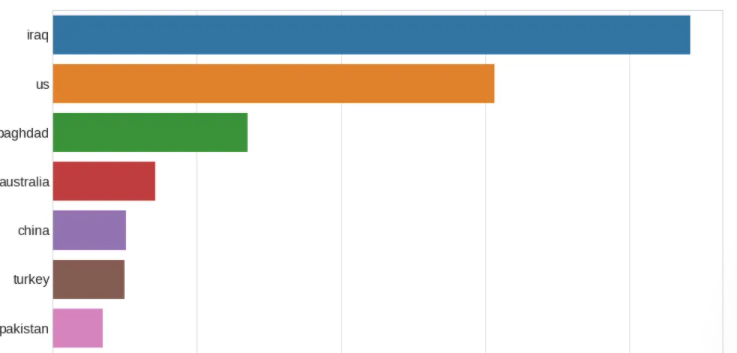

### вроде не надо - Exploration through parts of speach tagging in Python 

https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools

In [ ]:
# nltk.download('averaged_perceptron_tagger')

In [ ]:
# распределение по частям предложения

def pos(text):
    pos=nltk.pos_tag(word_tokenize(text))
    pos=list(map(list,zip(*pos)))[1]
    return pos

# tags=news['headline_text'].apply(lambda x : pos(x))
# tags=[x for l in tags for x in l]
# counter=Counter(tags)

x,y=list(map(list,zip(*counter.most_common(7))))
sns.barplot(x=y,y=x)
for sense in range(-1,2):
#     print(i)
    tags = [i[1] for i in nltk.pos_tag(sense_dict[sense])]
    freq_dist_positive=nltk.FreqDist(tags)
#     print("Most Common Positive Words : ",freq_dist_positive.most_common(20))
    counter=Counter(tags)
    x,y=list(map(list,zip(*counter.most_common(7))))
    fig, axs = plt.subplots(1, 1, figsize=(12, 7))
    sns.barplot(x=y,y=x).set_title('pos' if sense== 1 else  ('neg' if sense == -1 else 'neu'))

In [ ]:
# doc = nlp('The greatest comeback stories in 2019')
# displacy.render(doc, style='dep', jupyter=True, options={'distance': 90})

### вроде не надо - Exploring through text complexity
https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools

In [ ]:
# pip install textstat

In [ ]:

from textstat import flesch_reading_ease

clean_df['clean_text'].apply(lambda x : flesch_reading_ease(x)).hist()

In [ ]:
clean_df[clean_df.location !=''].location.value_counts().head(10)

###  Вопрос ГЛАВНЫЙ - корректно ли выполнен EDA, есть ли комментарии, что добавить и как продолжать? 

### отличия с изначальным вариантом:
    1. убрал emoji analysis
    2. delete n_grams
    3. clean_df.groupby('carrier').agg('mean') - убрал count
    4. убрал подсчет указанных слов 
    5. убрал топ-10 слов
    6. удалил боксплот по длине слов в корпусе
    7. удалил some sample features

### что добавить по EDA:
    1. V -  Mention times for each carrier per day
    2. V -  Q4. Sentiment Analysis for each carrier
    3. V -  b. Overall sentiments polarity for each carrier¶
    4. V -  соотношение сентиментов у каждого оператора
    6. V - распределение по времени по операторам
    8. V - график топ-25 значимых по tf-idf слов и биграмм
    10.V -  Frequent pos/negative words for each carrier
    11.V -  df.location.value_counts()

### Вопросы Артему:
    1. V - Зачем нужен TF-IDF , как его использовать в модели
    2. V - Зачем нужна часть EDA, в которой нет обработки данных
    3. V - для какой модели нужно косинусная трансформация?
    4. V - как добыть 60000 данных
    5. V - напомнить зачем логарифм в IDF

In [ ]:
clean_df.to_csv('upd_clean_df.csv')